In [16]:
import torch
from torch.linalg import matrix_norm as mn
import numpy as np
import create_data_upd as OD
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
instance='X'
rows = 400
cols = 10
k_sparse=5
sig1vt_supp=10
zt_noise_sigma=0.01
norm_data='Yes'
cs_ratio=0.25
red=400 
file_name = f"DECONET(synthetic our data)-10L-4000-red{red}-lr0.0001-mu100-initkaiming-datasets_{instance}_400x10_ksparse=5%_sig1vt_supp={sig1vt_supp}_zt_noise_sigma={zt_noise_sigma}_cs_ratio={cs_ratio}_normalizeDataset={norm_data}.pt"
state_dict = torch.load('/home-sipl/prj7482/'+file_name)
A=state_dict['A']

#enc = ENCODER(A)

checkpoint_name = f"save_datasets_{rows}x{cols}_ksparse={k_sparse}%_sig1vt_supp={sig1vt_supp}_zt_noise_sigma={zt_noise_sigma}.pt"
loaded_datasets = torch.load('/home-sipl/prj7482/'+checkpoint_name)
mean=loaded_datasets['mean']
std=loaded_datasets['std']
print('mean ',mean)
print('std ',std)

len_test = 1000
data = OD.Data(rows=rows, cols=cols, sig1vt_supp=sig1vt_supp, k_sparse=5,zt_noise_sigma=zt_noise_sigma)
X_dataset_test, C_dataset_test, Z_dataset_test = data.create_Dataset(len_test)

print('Checking X:')
test=torch.from_numpy(X_dataset_test).clone().float()
test=(test-mean)/std

W=state_dict['phi']
test=test.to(DEVICE)
# for i in range(len_test):
#     W*test[i,:,:]


/tmp/ipykernel_2142795/1970342327.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home-sipl/prj7482/'+file_name)
/tmp/ipykernel_2142795/197034

mean  0.018209636
std  6.454612
Checking X:


In [23]:
# for i in range(len_test):
#     W*x
x=test[0,:,:].flatten()
sparse_x=torch.matmul(W,x)



tensor(0., device='cuda:0')

In [41]:
WtW = W.t() @ W

# Check if determinant is zero
det_WtW = torch.linalg.det(WtW)
if det_WtW == 0 or torch.isnan(det_WtW):
    print("W^T W is singular or ill-conditioned. Applying regularization.")
    epsilon = 1e-6
    WtW += epsilon * torch.eye(W.shape[1], dtype=W.dtype, device=W.device)

    # Recompute the determinant after regularization
    det_WtW = torch.linalg.det(WtW)

# Compute normalization factor using regularization
normalization_factor = torch.sqrt(det_WtW)

# If determinant is still zero or NaN, use SVD
if normalization_factor == 0 or torch.isnan(normalization_factor):
    print("Normalization factor is zero or undefined. Using SVD.")
    U, singular_values, Vh = torch.linalg.svd(W, full_matrices=False)

    # Select non-zero singular values
    non_zero_singular_values = singular_values[singular_values > 1e-10]
    if non_zero_singular_values.numel() == 0:
        raise ValueError("W has no non-zero singular values. Cannot normalize.")

    # Compute normalization factor as the product of non-zero singular values
    normalization_factor = torch.prod(non_zero_singular_values)

# Normalize W x
Wx = W @ x
normalized_Wx = Wx / normalization_factor

print("Normalized W x:", normalized_Wx)


W^T W is singular or ill-conditioned. Applying regularization.
Normalization factor is zero or undefined. Using SVD.
Normalized W x: tensor([-inf, -inf, inf,  ..., -inf, inf, -inf], device='cuda:0')


ValueError: supplied range of [-inf, inf] is not finite

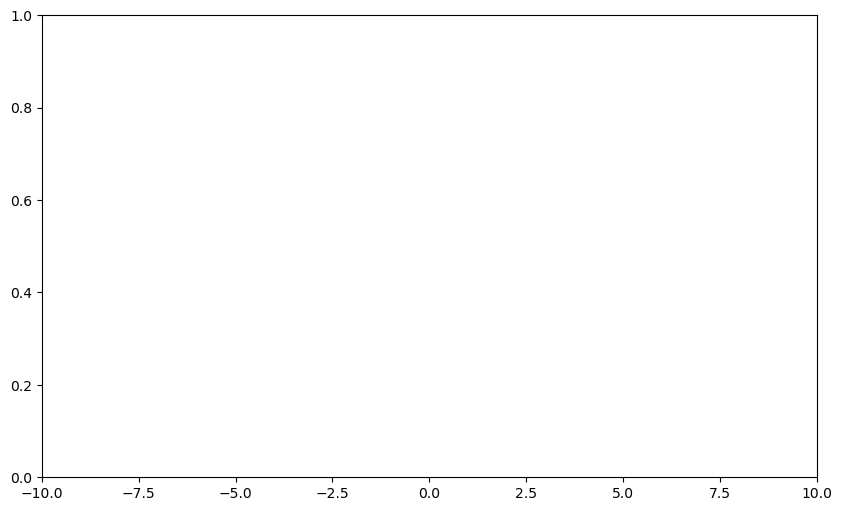

In [39]:
epsilon = 1e-6 
sparse_x_norm=sparse_x/torch.sqrt(torch.det(torch.matmul(W.T,W)+(epsilon*torch.eye(W.shape[1]).to(DEVICE))))
sparse_x_np = sparse_x_norm.detach().cpu().numpy()  # Ensure it's detached and on CPU
# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.xlim(-10,10)
plt.hist(sparse_x_np, bins=50, alpha=0.75, color='blue')  # Choose number of bins and transparency
plt.title('Histogram of Sparse Representation of X')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()



In [37]:
(epsilon*torch.eye(W.shape[1])).device

device(type='cpu')

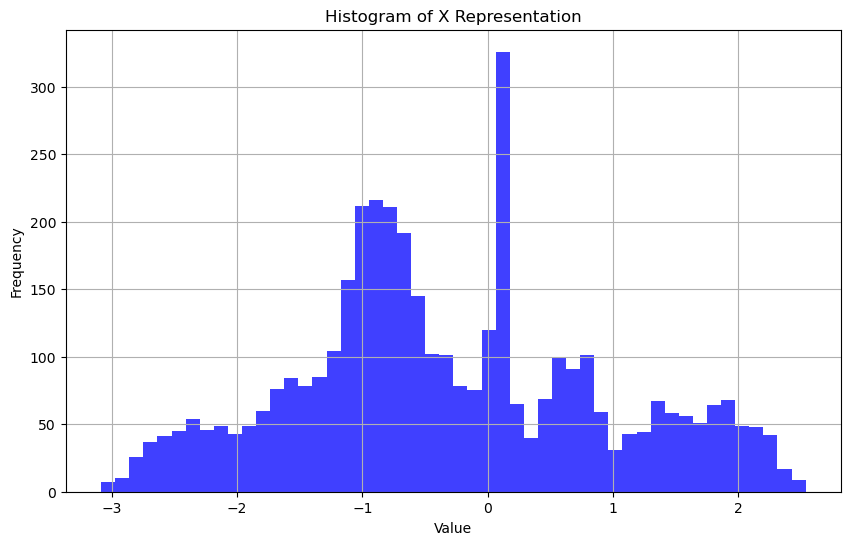

In [7]:
x_np = x.detach().cpu().numpy()  # Ensure it's detached and on CPU

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.hist(x_np, bins=50, alpha=0.75, color='blue')  # Choose number of bins and transparency
plt.title('Histogram of X Representation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

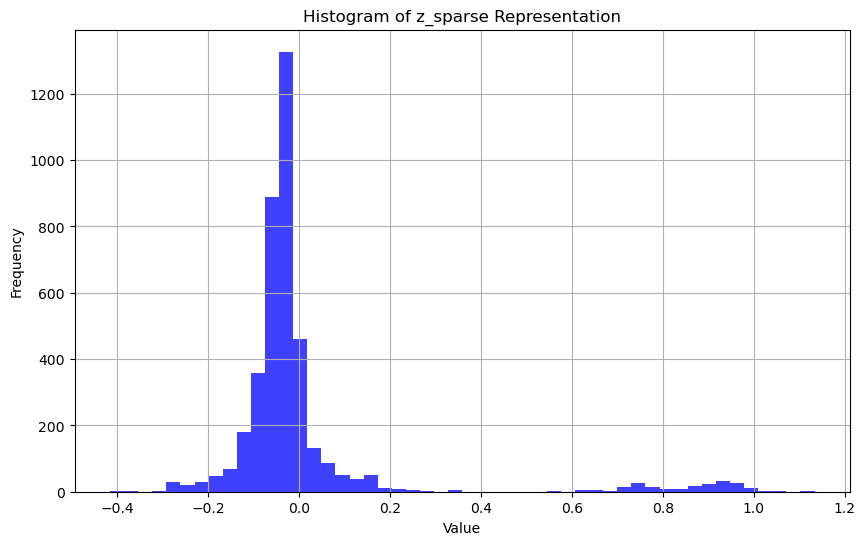

In [8]:
z=torch.from_numpy(Z_dataset_test[0,:,:]).clone().float().flatten()
# Create a tensor of 36,000 zeros
# zeros = torch.zeros(36000, dtype=z.dtype)
# z_sparse = torch.cat((z, zeros), dim=0)

sparse_z_np = z.detach().cpu().numpy()  # Ensure it's detached and on CPU

# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.hist(sparse_z_np, bins=50, alpha=0.75, color='blue')  # Choose number of bins and transparency
plt.title('Histogram of z_sparse Representation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

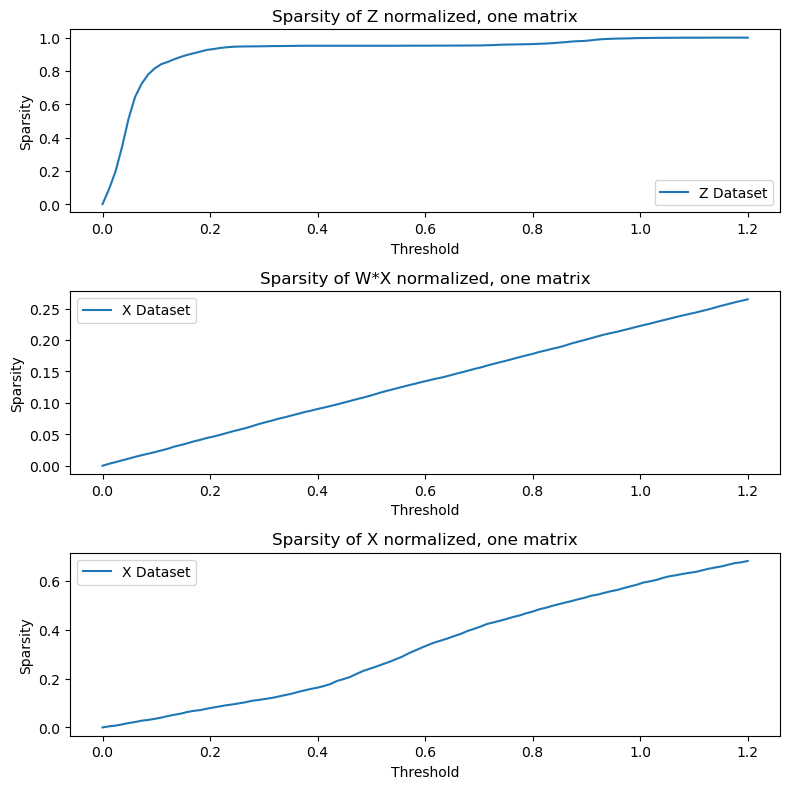

In [29]:
def calculate_sparsity(data, thresholds):
    sparsity_levels = []
    for threshold in thresholds:
        sparsity = np.sum(np.abs(data) < threshold) / data.size
        sparsity_levels.append(sparsity)
    return sparsity_levels

#Display sparse of normalized data
thresholds = np.linspace(0, 1.2, num=100)
x_np=x.detach().cpu().numpy()
# Calculate sparsity for each dataset
Z_dataset_sparsity = calculate_sparsity(sparse_z_np, thresholds)
X_AVG_dataset_sparsity = calculate_sparsity(sparse_x_np, thresholds)
X = calculate_sparsity(x_np, thresholds)
# Setting up the figure and axes
fig, axes = plt.subplots(3, 1, figsize=(8, 8))  # 2 rows, 1 columns
# Plot sparsity levels
axes[0].plot(thresholds, Z_dataset_sparsity, label='Z Dataset')
axes[0].set_title('Sparsity of Z normalized, one matrix')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Sparsity')
axes[1].plot(thresholds, X_AVG_dataset_sparsity, label='X Dataset')
axes[1].set_title('Sparsity of W*X normalized, one matrix')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Sparsity')
axes[2].plot(thresholds, X, label='X Dataset')
axes[2].set_title('Sparsity of X normalized, one matrix')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('Sparsity')

for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.show()

In [36]:
##Redandency = 1


tensor(205720.8125, device='cuda:0')